In [2]:
# Nikolaus Howe, May 2016
# pass it a string of events as a parameter, and it will parse and centre the events

import numpy as np
import sys
import ast
import h5py
from sklearn.cross_validation import train_test_split
from keras.models import model_from_json, Sequential
from keras.layers import Dense, Dropout, Activation, Convolution3D, Flatten, MaxPooling3D
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN not available)

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
# Given a list of distances and corresponding weights, calculate the weighted average
def findMidpoint(distance, energy):
    return np.average(distance, weights = energy)

In [3]:
# Given an array of interactions (x,y,z,E), returns the weighted average (avex, avey, avez)
def findEventMidpoint(event):
    xave = findMidpoint(event[:,0], event[:,3])
    yave = findMidpoint(event[:,1], event[:,3]) 
    zave = findMidpoint(event[:,2], event[:,3]) 
    return (xave, yave, zave)

In [4]:
# Check if between bounds
def within(value, mymin, mymax):
    return (value >= mymin and value <= mymax)

In [5]:
# Given an event, get the 20x20x30 array of energies around its barycentre
def getEventArray(event):
    
    # Get the event midpoint
    midpoint = findEventMidpoint(event)
    
    # Get the limit points for our grid
    xmin = midpoint[0] - 10
    xmax = midpoint[0] + 10
    ymin = midpoint[1] - 10
    ymax = midpoint[1] + 10
    
    # Create the empty array to put the energies in
    final_array = np.zeros((20, 20, 25))
    
    # Fill the array with energy values, if they exist
    #for element in event:
    #    if within(element[0], xmin, xmax) and within(element[1], ymin, ymax) and within(element[2], zmin, zmax):
    #        final_array[element[0], element[1], element[2]] = element[3]
  
    # Fill the array with energy values, if they exist
    for x,y,z,E in event:
        if within(x, xmin, xmax) and within(y, ymin, ymax):
            final_array[x-xmin,y-ymin,z] = E
    return final_array

In [6]:
def convertFile(filename):
    with open(filename) as myfile:
        my_events_string = myfile.read().replace('\n', '')
    my_events = ast.literal_eval(my_events_string)
    event_list = []
    for event in my_events:
        event_list.append( np.array(event) )
    energy_array_list = []
    for event in event_list:
        energy_array_list.append(getEventArray(event))
    store = h5py.File(filename+'.h5')
    store['images'] = e
    #print e.shape
    store.close()

In [7]:
#convertFile("event_list.txt")

In [8]:
# Open the file
with open(str("event_list.txt"), 'r') as myfile:
    my_events_string = myfile.read().replace('\n', '')

In [9]:
# Parse the input string into a list of lists of tuples
my_events = ast.literal_eval(my_events_string)

In [10]:
# Turn the list of lists of tuples into a list of arrays of arrays
event_list = []
for event in my_events:
    event_list.append( np.array(event) )

In [11]:
#event_list[0]

In [12]:
# Create 20x20x30 energy arrays centered around the barycentre of each event
energy_array_list = []
for event in event_list:
    energy_array_list.append(getEventArray(event))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [13]:
store= h5py.File('/data/vlimant/LCD/Pi0100GeV_0.txt.h5','r')
energy_array_list = store['images']
energy_array_list.shape

(50, 20, 20, 25)

In [14]:
e=np.asarray(energy_array_list)
type(e)

numpy.ndarray

In [15]:
def get_dataset(directory):
    import os
    big=None
    for fn in filter(None,os.popen('ls %s*.txt.h5'%directory).read().split('\n')):
        #print fn
        store=h5py.File(fn,'r')
        if big==None:
            big = np.asarray(store['images'])
            print 'init'
        else:
            a = np.asarray(store['images'])
            #print a.shape
            #print big.shape
            big = np.concatenate((big, a), axis=0)
            #print 'add'
        store.close()
    print big.shape
    return big

In [16]:
def save_dataset(directory, dataset):
    store = h5py.File('%s_fulldataset.h5'%directory, 'w')
    store['images'] = dataset
    store.close()

In [6]:
def load_dataset(directory):
    store = h5py.File('%s_fulldataset.h5'%directory, 'r')
    return store['images']

In [18]:
def store_model(model, label):
    # Save the model and weights
    # Save as JSON
    open("%s.json"%label, 'w').write(model.to_json())
    
    # Save the weights
    model.save_weights("%s.h5"%label)

In [19]:
def load_model(label):
    model = model_from_json(open('%s.json'%label).read())
    model.load_weights('%s.h5'%label)
    return model

#### The next two commands extract the gammas and pi0s as nparrays of 20x20x25 event arrays

In [20]:
#signal = get_dataset('/data/vlimant/LCD/Gamma100GeV')

In [21]:
#bkg = get_dataset('/data/vlimant/LCD/Pi0100GeV')

In [22]:
# Save the datasets for faster future loading
#save_dataset("/data/vlimant/LCD/Gamma100GeV", signal)
#save_dataset("/data/vlimant/LCD/Pi0100GeV", bkg) 

In [7]:
# Load the datasets
signal = load_dataset("/data/vlimant/LCD/Gamma100GeV")
bkg = load_dataset("/data/vlimant/LCD/Pi0100GeV")

#### Prepare the data

In [48]:
# 1 is signal, 0 is background
X = np.concatenate( (signal, bkg), axis=0 )
Y = np.zeros( (len(X)) )
Y[:len(signal)] = 1
p = np.random.permutation(len(X))
X = X[p]
Y = Y[p]
X = X.reshape((X.shape[0], 1, 20, 20, 25))

train_data, test_data, train_labels, test_labels = train_test_split(X, Y, test_size=0.33, random_state=42)

#### Create and train the model

In [58]:
# Convolutional Layers
model = Sequential()
model.add(Convolution3D(3, 4, 4, 5, input_shape = (1, 20, 20, 25), activation='relu'))
model.add(MaxPooling3D())
model.add(Flatten())

# Dense layer
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, init='uniform', activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='sgd')
model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
convolution3d_8 (Convolution3D)    (None, 3, 17, 17, 21243         convolution3d_input_8[0][0]      
____________________________________________________________________________________________________
maxpooling3d_7 (MaxPooling3D)      (None, 3, 8, 8, 10) 0           convolution3d_8[0][0]            
____________________________________________________________________________________________________
flatten_7 (Flatten)                (None, 1920)        0           maxpooling3d_7[0][0]             
____________________________________________________________________________________________________
dense_14 (Dense)                   (None, 100)         192100      flatten_7[0][0]                  
___________________________________________________________________________________________

In [59]:
# Train the network
model.fit(train_data, train_labels, nb_epoch=30, batch_size=100, verbose=1)

Epoch 1/30
54236/54236 [==============================] - 58s - loss: 0.5353    
Epoch 2/30
54236/54236 [==============================] - 58s - loss: 0.3472    
Epoch 3/30
54236/54236 [==============================] - 58s - loss: 0.3054    
Epoch 4/30
54236/54236 [==============================] - 58s - loss: 0.2874    
Epoch 5/30
54236/54236 [==============================] - 58s - loss: 0.2771    
Epoch 6/30
54236/54236 [==============================] - 58s - loss: 0.2710    
Epoch 7/30
54236/54236 [==============================] - 58s - loss: 0.2626    
Epoch 8/30
54236/54236 [==============================] - 58s - loss: 0.2590    
Epoch 9/30
54236/54236 [==============================] - 58s - loss: 0.2532    
Epoch 10/30
54236/54236 [==============================] - 58s - loss: 0.2455    
Epoch 11/30
54236/54236 [==============================] - 58s - loss: 0.2442    
Epoch 12/30
54236/54236 [==============================] - 58s - loss: 0.2420    
Epoch 13/30
54236/54236 [

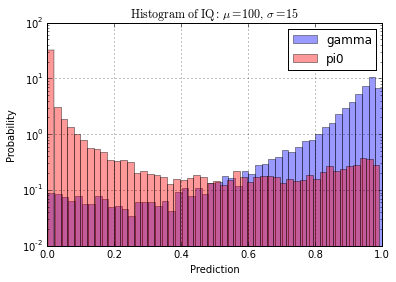

In [65]:
# Get the test signal and background to make the histogram
test_signal = test_data[np.where(test_labels==1)]
test_bkg    = test_data[np.where(test_labels==0)]

# Calculate the probabilities for the test sets
p_signal    = model.predict(test_signal)
p_bkg       = model.predict(test_bkg)

# Draw classification histogram
plt.hist(p_signal, 50, normed=1, facecolor='blue', alpha=0.4, label='gamma')
plt.hist(p_bkg , 50, normed=1, facecolor='red' , alpha=0.4, label='pi0')
plt.xlabel('Prediction')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
plt.yscale('log')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

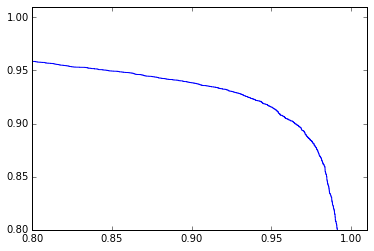

In [66]:
# Get classification predictions
predictions = model.predict(test_data)

# Draw the ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(test_labels, predictions)
plt.xlim([.8, 1.01])
plt.ylim([.8, 1.01])
plt.plot( tpr, 1-fpr )

#### Visualization

In [9]:
event = bkg[99]
plot_list = []
for i in range(25):
    plot_list.append(event[:,:,i])

In [10]:
plot_list[1].shape

(20, 20)

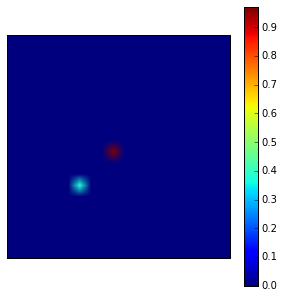

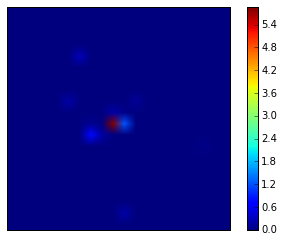

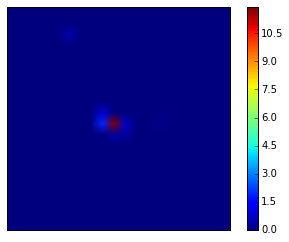

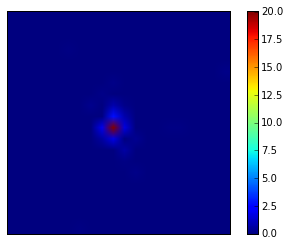

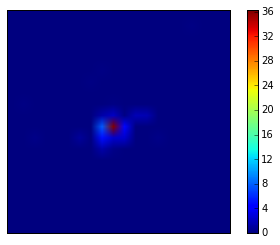

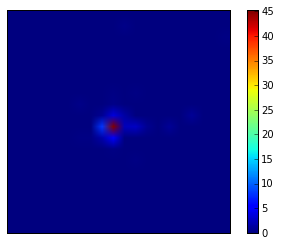

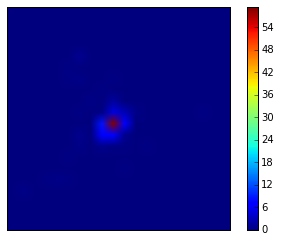

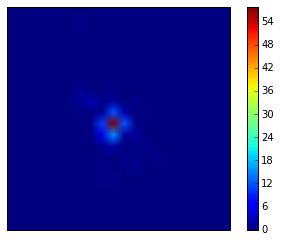

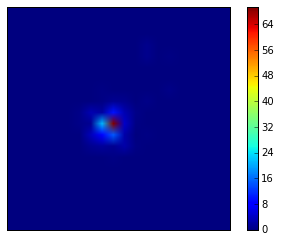

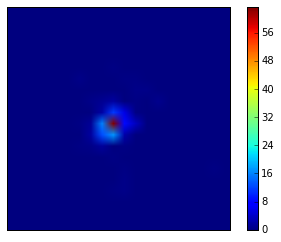

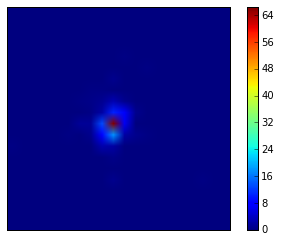

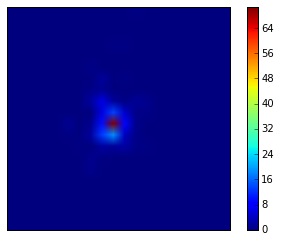

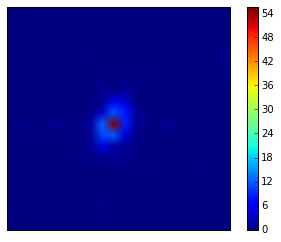

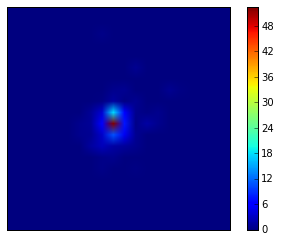

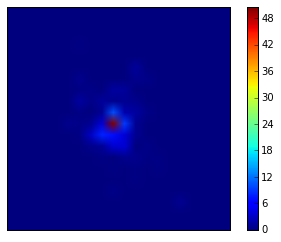

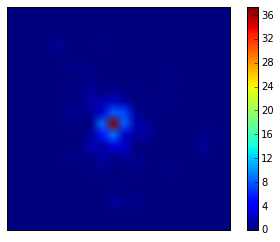

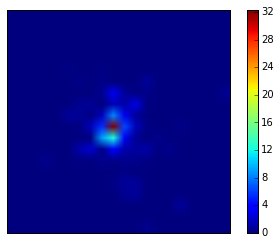

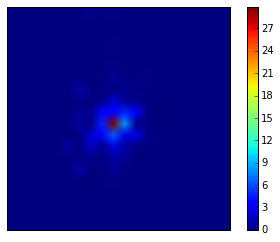

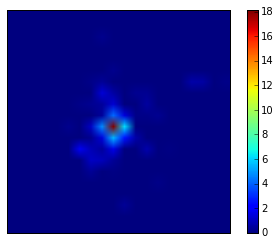

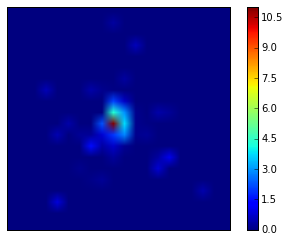

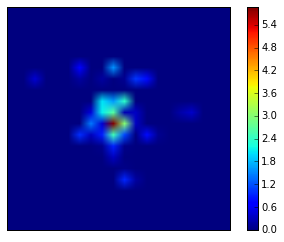

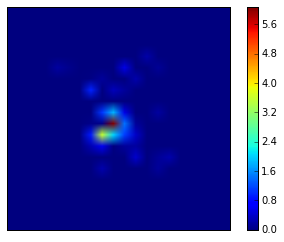

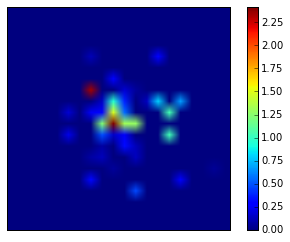

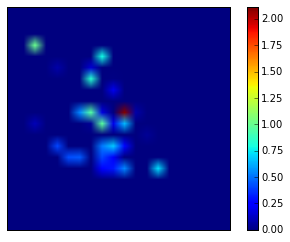

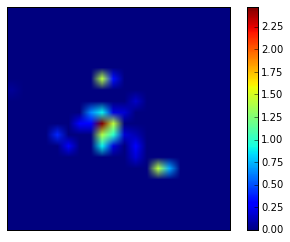

In [11]:
plt.figure(figsize=(5,5))
for l in range(25):
    plt.imshow(event[...,l])
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.show()

NameError: name 'event_list' is not defined

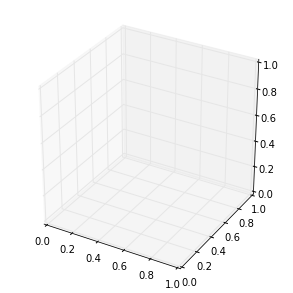

In [8]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
e=0
ax.scatter( event_list[e][:,0], event_list[e][:,1], event_list[e][:,2] )
plt.xlabel('x')
plt.ylabel('y')

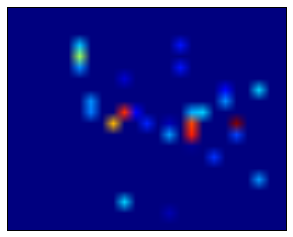

In [71]:
plt.figure(figsize=(5,5))
plt.imshow(event[15,:,:])
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
# Not sure what this is for

In [ ]:
e=np.asarray(energy_array_list)

In [ ]:
store = h5py.File('mydata.h5')
store['images'] = e
store.close()

In [ ]:
store = h5py.File('mydata.h5','r')
new_e = store['images']
new_e.shape

#  OLD

In [ ]:
# Construct ROC curve
roc_points_signal = []
roc_points_bkg  = []

# Find min and max values of data
minval = min(p_signal.min(), p_bkg.min())
maxval = max(p_signal.max(), p_bkg.max())

for threshold in range(1001):

    # We will vary threshold from 0 to 1
    threshold = threshold/1000.0*(maxval - minval) + minval

    # Calculate proportion of 'zero' elements below the threshold
    signal_above_prop = len(np.where(p_signal > threshold)[0]) / float(len(p_signal))

    # Calculate proportion of 'one' elements above the threshold
    bkg_below_prop = len(np.where(p_bkg < threshold)[0]) / float(len(p_bkg))
    
    # Add this point to our ROC points
    roc_points_signal.append(signal_above_prop)
    roc_points_bkg.append(bkg_below_prop)
    
# Draw ROC curve
plt.scatter(roc_points_signal, roc_points_bkg)
plt.xlim([0., 1.01])
plt.ylim([0., 1.01])
plt.show()